# Linear regression

Linear regression is a statistical method used to establish a relationship between a dependent variable (also known as the response variable) and one or more independent variables (also known as the predictor variables). It assumes that the relationship between the variables is linear, meaning that the change in the response variable is directly proportional to the change in the predictor variables.

The goal of linear regression is to fit a line that best explains the relationship between the variables, which can then be used to make predictions about the response variable. The line is estimated by minimizing the sum of the squared differences between the observed values of the response variable and the predicted values from the model.

We'll be using it mainly as a way of explaining our data. We start out with the mpg-dataset, widely used in R (the programming language).

In [1]:
# When trying this notebook, you are using a virtual environment, no?
# Because you should be.

!pip install pandas
!pip install matplotlib
!pip install scikit-learn

In [2]:
# load mpg.csv as a pandas dataframe
import pandas as pd
import numpy as np

mpg = pd.read_csv('files/mpg.csv')
mpg.head()

,Unnamed: 0,manufacturer,model,displ,year,cyl,trans,drv,cty,hwy,fl,class
0,1,audi,a4,1.8,1999,4,auto(l5),f,18,29,p,compact
1,2,audi,a4,1.8,1999,4,manual(m5),f,21,29,p,compact
2,3,audi,a4,2.0,2008,4,manual(m6),f,20,31,p,compact
3,4,audi,a4,2.0,2008,4,auto(av),f,21,30,p,compact
4,5,audi,a4,2.8,1999,6,auto(l5),f,16,26,p,compact


We start out with a simple graph of engine displacement vs highway miles per gallon (displ vs hwy).

<Axes: xlabel='displ', ylabel='hwy'>

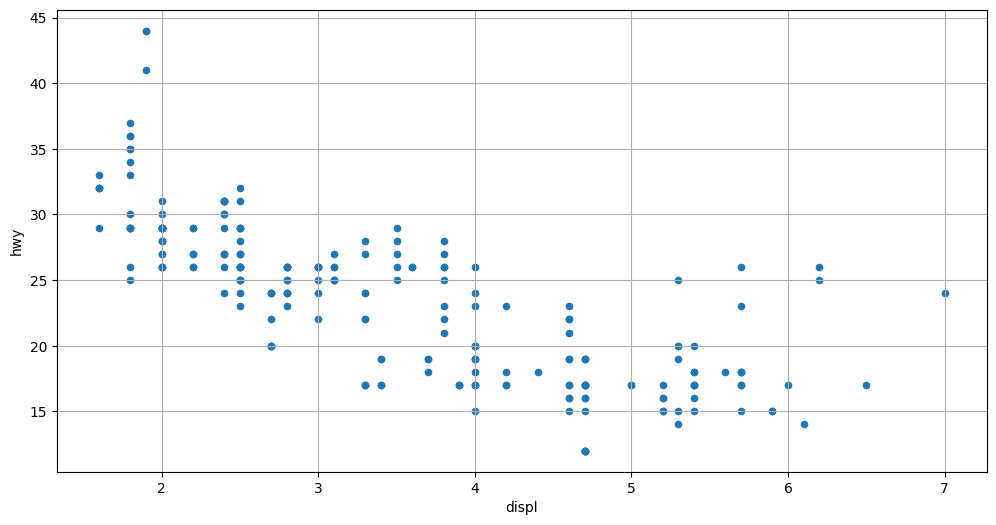

In [3]:
# A scatterplot of displ vs hwy in mpg
mpg.plot(kind='scatter', x="displ", y="hwy", grid=True,fontsize=10, figsize=(12, 6))


 In this graph we can already see a bit of a linear trendline (bigger engine means lower miles per gallon). But we want to quantify this, so we can draw a couple of random lines on the graph and see which is best.

 (https://stackoverflow.com/questions/39732288/pandas-how-to-plot-a-line-in-a-scatter-and-bring-it-to-the-back-front)

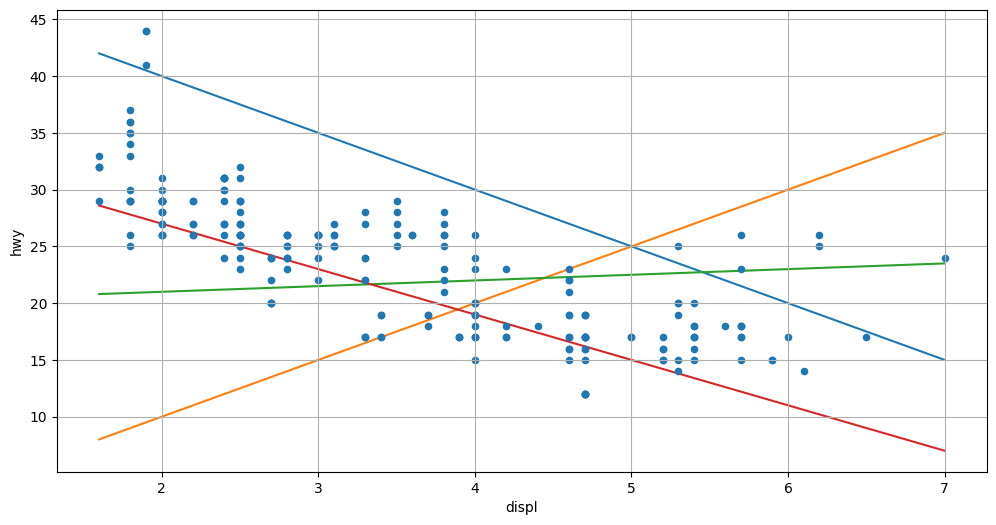

In [4]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12,6))

mpg.plot(kind='scatter', x="displ", y="hwy", grid=True,fontsize=10, ax=ax) 

# some predefined lines, as fully random would be really weird
a = (-5, 5, 0.5, -4)
b = (50, 0, 20, 35)

# add to graph
for i in range(len(a)):
    line = np.linspace(min(mpg.displ), max(mpg.displ), 10)
    x_line = (a[i] * line) + b[i]
    ax.plot(line, x_line, zorder=-1)

These lines are our model. When we have a displacement of 4 the blue line will predict a value of 30. You can calculate this using the values we used for a and b:

In [5]:
for i in range(len(a)):
    predict = a[i] * 4 + b[i]
    print(f"a= {a[i]}, b= {b[i]}, predict= {predict}")

a= -5, b= 50, predict= 30
a= 5, b= 0, predict= 20
a= 0.5, b= 20, predict= 22.0
a= -4, b= 35, predict= 19


But what line is better? The line needs to go down (blue and red), and red is better than blue but to low. What we need is a metric that objectively measures the 'goodness' of a line. For this we need the error. The error is the difference between the predicted value and the actual value.

Let's calculate the error for the first car in the dataset.

In [6]:
print(f"actual= {mpg.hwy[0]}")


for i in range(len(a)):
    predict = a[i] * 4 + b[i]
    error = predict - mpg.hwy[0]
    print(f"a= {a[i]}, b= {b[i]}, predict= {predict}, error= {error}")


actual= 29
a= -5, b= 50, predict= 30, error= 1
a= 5, b= 0, predict= 20, error= -9
a= 0.5, b= 20, predict= 22.0, error= -7.0
a= -4, b= 35, predict= 19, error= -10


As you can see the error varies wildly and is quite large in some cases. (Which is normal as we are simply using random lines as a model.) But how do we use this error (or the combination of all errors for every line in our data) to check the model?

There are a couple of options:

* Simply add the errors: Some errors are positive, others are negative. This doesn’t add up well.
* Add the absolute value of the errors: Could work but we really want to penalize the big errors.
* Mean squared error (MSE): We square all the errors and take the average (mean). This is our metric.
* Root mean squared error (RMSE): the MSE, but we take the root of this value.

The MSE is a good measure: squaring takes care of the sign of the error (or the error above or below the prediction-line), but the result we get is an error in "miles per gallon squared". This does not compare to the actual value in the dataset. We van fix this by taking the root of the value. Et voila: RMSE.

![](files/2023-04-11-19-26-30.png)

But let's calculate these errors for our four lines.

In [7]:
# function calculates the predicted value for every line we drew earlier (every model)
def predict(x):
    predictions = []
    for i in range(len(a)):
        predictions.append(a[i] * x + b[i])
    return predictions

# Go over data, add predicted values to dataframe
mpg['pred1'], mpg['pred2'], mpg['pred3'], mpg['pred4'] = predict(mpg.displ)
# mpg['predicted'] = mpg.displ.apply(predict)

mpg.head()

,Unnamed: 0,manufacturer,model,displ,year,cyl,trans,drv,cty,hwy,fl,class,pred1,pred2,pred3,pred4
0,1,audi,a4,1.8,1999,4,auto(l5),f,18,29,p,compact,41.0,9.0,20.9,27.8
1,2,audi,a4,1.8,1999,4,manual(m5),f,21,29,p,compact,41.0,9.0,20.9,27.8
2,3,audi,a4,2.0,2008,4,manual(m6),f,20,31,p,compact,40.0,10.0,21.0,27.0
3,4,audi,a4,2.0,2008,4,auto(av),f,21,30,p,compact,40.0,10.0,21.0,27.0
4,5,audi,a4,2.8,1999,6,auto(l5),f,16,26,p,compact,36.0,14.0,21.4,23.8


In [8]:
# compare the RMSE-values:
for i in range(len(a)):
    rmse = np.sqrt(np.mean((mpg.hwy - mpg[f"pred{i+1}"])**2))
    print(f"a= {a[i]}, b= {b[i]}, RMSE= {rmse}")

a= -5, b= 50, RMSE= 10.140677163450837
a= 5, b= 0, RMSE= 13.134576278551737
a= 0.5, b= 20, RMSE= 6.670399595918582
a= -4, b= 35, RMSE= 4.513512476087207


As you can see the last line (the blue one) is the best, but it's still only a little bit better than the one just above, the green one. And that one even goes in the wrong direction (up in stead of down).

You might have wandered if manually calulating the RMSE is really the only option. It isn't: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_squared_error.html

You could now start tweaking a and b, trying to get the rmse as low as possible. Or you could use an existing toolkit, like the really good scikit-learn, to generate the best possible trendline.

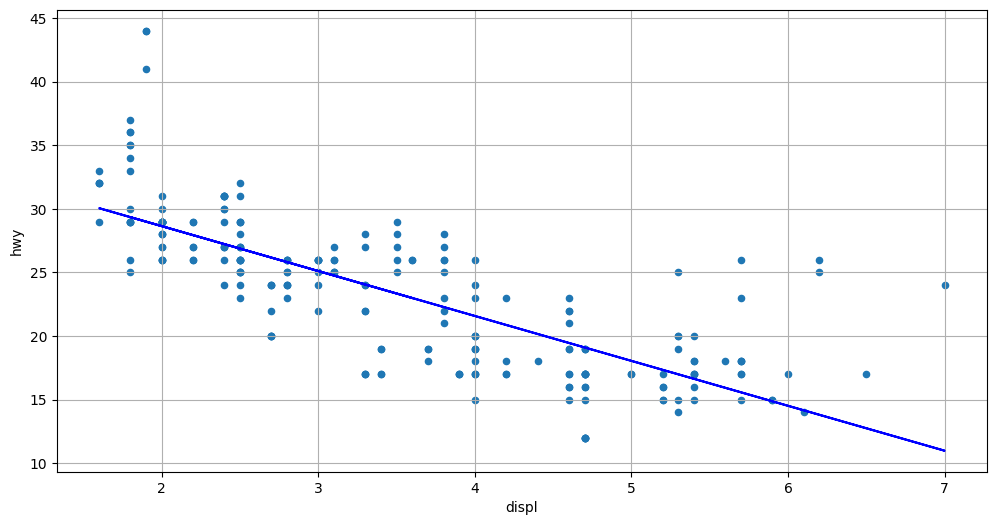

In [9]:
from sklearn import datasets, linear_model

x = mpg.displ.values.reshape(-1, 1)
y = mpg.hwy.values.reshape(-1, 1)

regr = linear_model.LinearRegression()
model = regr.fit(x, y)

fig, ax = plt.subplots(figsize=(12,6))

mpg.plot(kind='scatter', x="displ", y="hwy", grid=True,fontsize=10, ax=ax) 
plt.plot(x, regr.predict(x), color='blue')


Looks a lot like our last line. But what were the values for A and B that were optimal? And what RMSE doe we have now? Note how we use the scikit-RMSE-calculator now.

In [10]:
from sklearn.metrics import mean_squared_error

print(f"a= {model.coef_[0][0]}, b= {model.intercept_[0]}")

mpg['model_predicted'] = model.predict(mpg.displ.values.reshape(-1, 1))
print("New RMSE:", np.sqrt(mean_squared_error(mpg.hwy, mpg.model_predicted)))

a= -3.5305888061689235, b= 35.69765105184459
New RMSE: 3.819556631201452


As you can see, our wild guess of -4 and 35 wasn't that bad. The RMSE we had, 4.513512476087207, was only a bit bigger than 3.819556631201452.

Is this a bad RMSE? Well, we're predicting hwy which is between 12 and 44. When we guess a value it's on average 3.8 off the actual value, which comes down to more than 10% . That really isn't that good so when doing data science you should now keep on digging.

Let's take a look at the residuals.

<Axes: xlabel='displ', ylabel='residuals'>

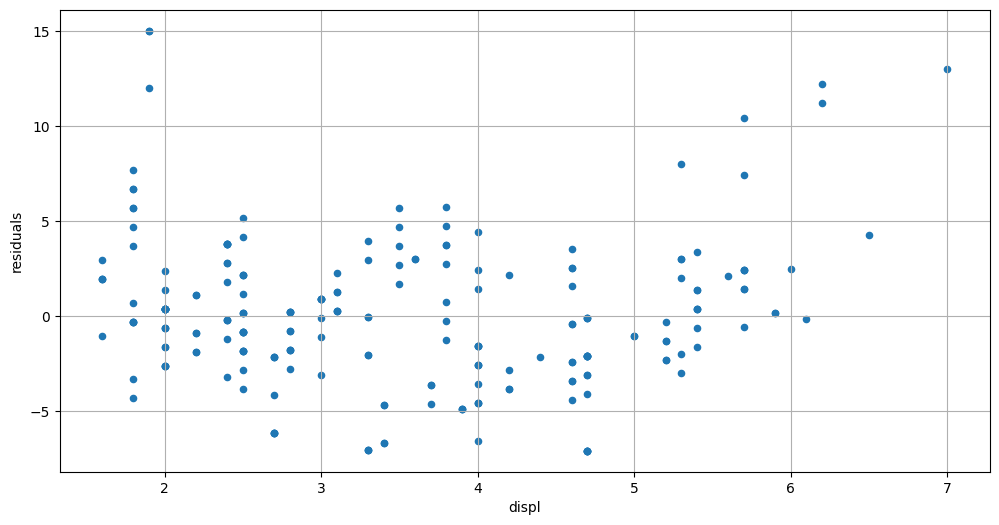

In [11]:
mpg['residuals'] = mpg['hwy'] - mpg['model_predicted']
mpg.plot(kind='scatter', x="displ", y="residuals", grid=True,fontsize=10, figsize=(12, 6))


Another plot is a density plot of the residuals. If it's a perfect gaussian distribution (the normal curve) than the model is equally perfect.

<Axes: ylabel='Density'>

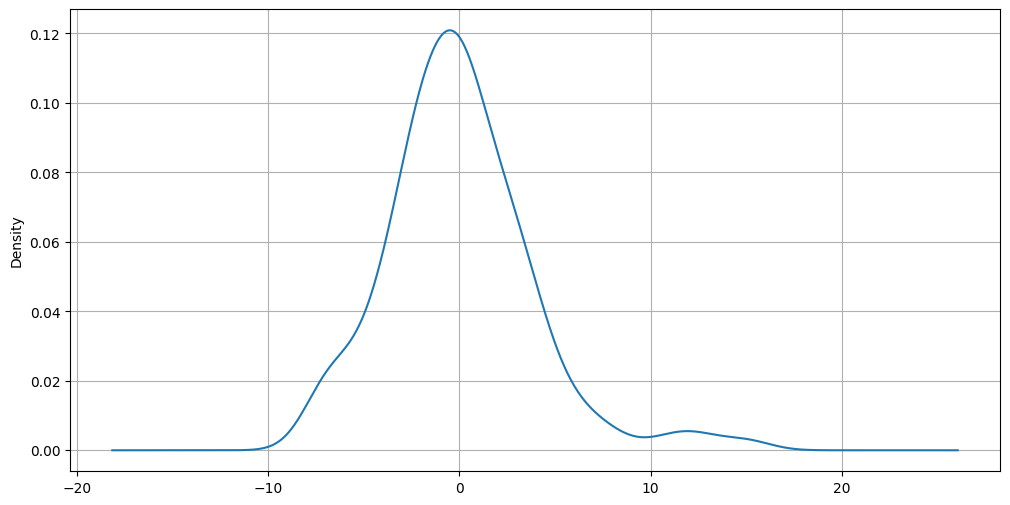

In [12]:
mpg.residuals.plot.density(grid=True,figsize=(12, 6))

And it isn't. There's a trail on the left (the bump from 10 on) that corresponds to the dots in the upper right corner of the scatterplot. This is data that is not behaving according to our model.

* Is a linear regression the correct model?
* Do I have to split up the data?

The last one, if you remember the mpg-dataset, is actually true: if you calculate trends per type of vehicle (compact, minivan, suv, ... ) you'll get better results. In fact, the misbehaving dots are the 2seater-cars: sports cars with large engines and low weight giving them good miles per gallons. Any decent prediction will have to include this.

In [13]:
# just quick lookups
print(min(mpg.hwy), max(mpg.hwy))
print(mpg["class"].unique())

12 44
['compact' 'midsize' 'suv' '2seater' 'minivan' 'pickup' 'subcompact']
